In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Prebuild face detection model 

In [2]:
pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# General imports 

In [3]:
import torch 

use_cuda  = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(42)
print(device)

cuda


# Transforms Dataset 

In [4]:
import os
from PIL import Image
import torch 
from torch.utils.data import Dataset   # to create a dataset for reterving the data from the diectories
from torchvision import transforms
from facenet_pytorch import MTCNN

root_directory = r'/kaggle/input/face-classification-deep-learning-cs-405/dataset/train'

# Define the data transform 
transform  = transforms.Compose([
    transforms.Resize((160 , 160)),
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self , root_directory):
        self.root_directory = root_directory
        self.identity_directories = os.listdir(root_directory)
        self.transform = transform
        self.mtcnn = MTCNN()
        self.identity_mapping  = {identity:label for label,identity in enumerate(self.identity_directories)}
        self.data = []
        for identity_label , identity in enumerate(self.identity_directories):
            images  = os.listdir(os.path.join(root_directory , identity))
            for image in images:
                image_path = os.path.join(root_directory , identity , image)
                self.data.append((image_path , identity_label))       
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        image_path, identity_label = self.data[index]
        img = Image.open(image_path)

        # Use MTCNN for face detection and alignment
        boxes, probs = self.mtcnn.detect(img)

        # If faces are detected, crop and align them
        if boxes is not None:
            face = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))  # Cropping the face

            # Apply transform to the cropped face
            face_transformed = self.transform(face)
            return face_transformed, torch.tensor(identity_label)

        else:
            return None
        
                
dataset = CustomDataset(root_directory)

In [5]:
from torch.utils.data import DataLoader

#Spliting the data into traning ans validation and test sets
train_size = int(0.7 * len(dataset))
validation_size = int(0.15 * len(dataset))
test_size = len(dataset)  - train_size - validation_size 

#spliting the data
train_data , validation_data , test_data = torch.utils.data.random_split(dataset , [train_size , validation_size , test_size])

#define the batch size for the dataloaders
batch_size = 128

#creating the data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=lambda x: [sample for sample in x if sample is not None], num_workers=2)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: [sample for sample in x if sample is not None])
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: [sample for sample in x if sample is not None])


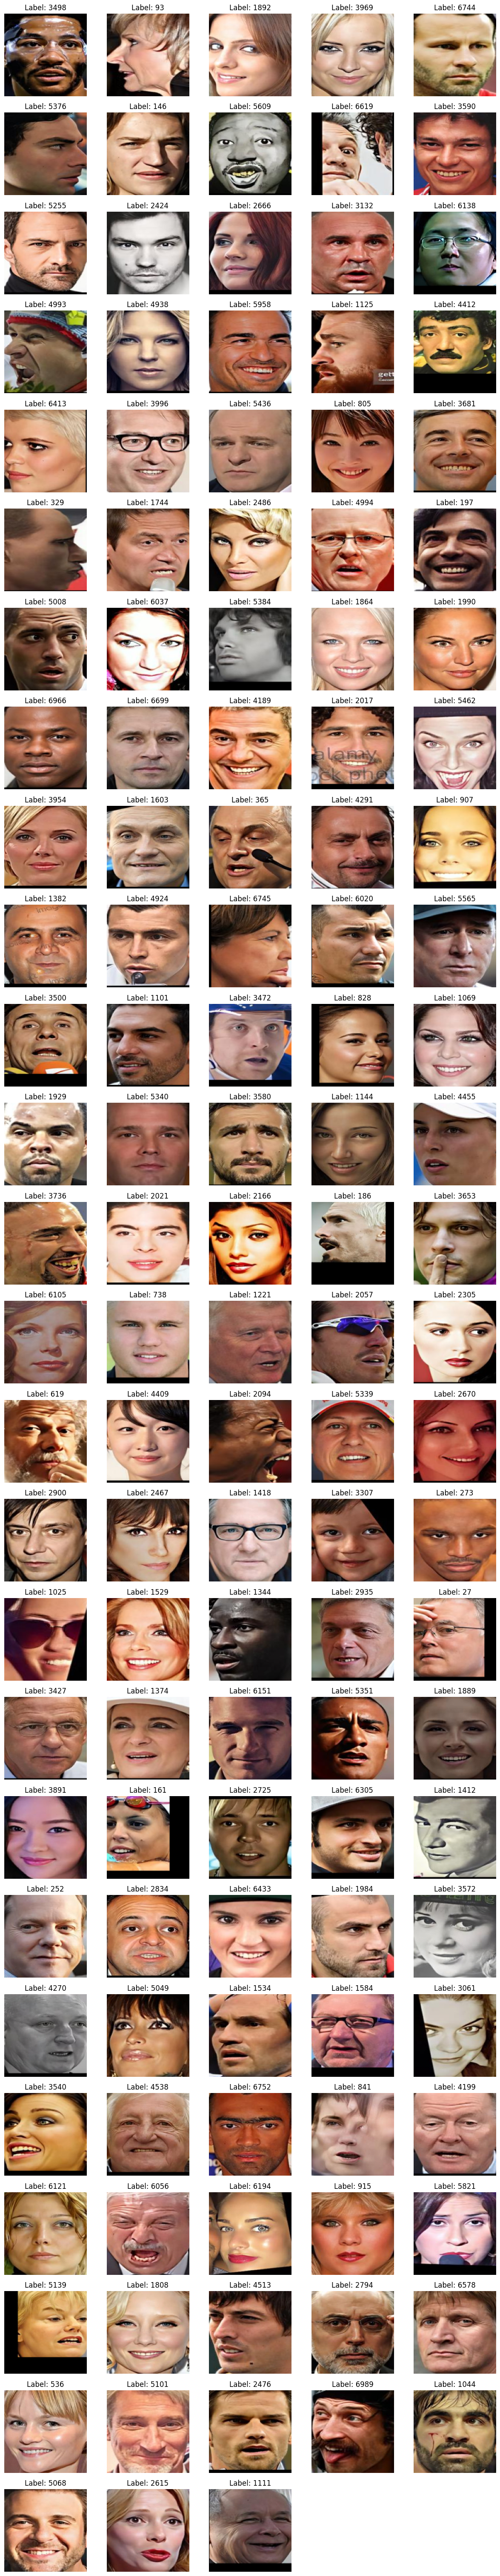

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(loader):
    # Get a batch of data
    data_iter = iter(loader)
    batch = next(data_iter)

    inputs, labels = zip(*batch)

    # Convert the batch to NumPy arrays
    inputs = np.array([item.numpy() for item in inputs])

    # Define a function to display images and labels
    def show_images(images, labels):
        num_images = len(images)
        num_cols = 5  # Number of columns for image display
        num_rows = (num_images + num_cols - 1) // num_cols

        plt.figure(figsize=(15, 3 * num_rows))
        for i in range(num_images):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(np.transpose(images[i], (1, 2, 0)))
            if labels is not None:
                plt.title(f"Label: {labels[i]}")  # Show label as title
            plt.axis("off")

    show_images(inputs, labels)
    plt.show()

display_images(train_loader)

In [7]:
from facenet_pytorch import InceptionResnetV1

# Set num_classes to 7000
num_classes = 7000

# Initialize the InceptionResnetV1 model
model = InceptionResnetV1(pretrained='vggface2', device=device, classify=True, num_classes=num_classes)

layers_to_unfreeze = 15  # Number of layers to keep unfrozen
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers
for param in list(model.parameters())[-layers_to_unfreeze:]:
    param.requires_grad = True
    

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [8]:
import torch.nn as nn
from torch import optim

#using cross-entropy for loss for classification
criterion  = nn.CrossEntropyLoss()


#using the Adam optimizer
optimizer = optim.Adam(model.parameters() , lr = 0.001)

checkpoint_path = '/kaggle/working/checkpoint.pth'
best_val_checkpoint_path = '/kaggle/working/best_val_checkpoint.pth'

torch.save(model.state_dict(), checkpoint_path)
torch.save(model.state_dict(), best_val_checkpoint_path)

# Model traning script

In [ ]:
from tqdm import tqdm

num_epochs = 2

def train_model(model):
    model.to(device)
    model.train()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Wrap the training loader with tqdm for a progress bar
        for batch in tqdm(train_loader):
            if batch is not None:
                inputs, labels = zip(*batch)
                inputs = torch.stack(inputs).to(device)
                labels = torch.stack(labels).to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy * 100:.2f}%')

        # Save a checkpoint every epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_accuracy
        }, checkpoint_path)

        # Check validation accuracy and save the best model
        val_loss, val_accuracy = evaluate_model(model, validation_loader)

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')


        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'accuracy': epoch_accuracy
            }, best_val_checkpoint_path)

    print('Training complete.')

    # Plotting training loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Plotting validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    valLoss = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = zip(*batch)
            inputs = torch.stack(inputs).to(device)
            labels = torch.stack(labels).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valLoss += loss.item()

            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    valLoss = valLoss / len(validation_loader)
    accuracy = correct_predictions / total_samples
    return valLoss, accuracy

# Usage example
train_model(model)

 32%|███▏      | 242/766 [19:45<44:47,  5.13s/it]  

In [ ]:
def validate_model(model):
    # Load model from the checkpoint
    checkpoint = torch.load(best_val_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(validation_loader):
            if batch is not None:
                val_inputs, val_labels = zip(*batch)
                val_inputs = torch.stack(val_inputs).to(device)
                val_labels = torch.stack(val_labels).to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                correct_predictions += (val_predicted == val_labels).sum().item()

    val_loss = running_loss / len(validation_loader)
    val_accuracy = correct_predictions / total_samples

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Usage example
validate_model(model)

In [ ]:
def test_model(model):
    # Load model from the best validation checkpoint
    checkpoint = torch.load(best_val_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            if batch is not None:
                test_inputs, test_labels = zip(*batch)
                test_inputs = torch.stack(test_inputs).to(device)
                test_labels = torch.stack(test_labels).to(device)

                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_labels)

                running_loss += test_loss.item()

                _, test_predicted = torch.max(test_outputs, 1)
                total_samples += test_labels.size(0)
                correct_predictions += (test_predicted == test_labels).sum().item()

    # Calculate the mean loss and accuracy over all batches
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_predictions / total_samples

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

# Usage example
test_model(model)